In the [_Novel Peptides_](Novel Peptides.ipynb) and [_Variation Analysis_](Variation Analysis.ipynb) chapters, novel and variant peptides were identified by Johansson _et al._ [(2)](https://gtpb.github.io/IBIP19/pages/proteogenomics/references) using a proteogenomic search strategy, where genomic data are used to inform the proteomics search strategy. It is possible to use RNA sequencing data complementarily or instead of the genetic sequence to identify non-canonical protein products.

##### [❔](https://github.com/GTPB/IBIP19/blob/master/pages/proteogenomics/answers.md#what-are-the-advantages-and-shortcomings-of-using-transcript-sequences-instead-of-or-in-addition-to-genomic-data) _What are the advantages and shortcomings of using transcript sequences instead of or in addition to genomic data?_

## Libraries

We will need the following libraries, please make sure that they are installed.

In [9]:

library(conflicted)
library(tidyr)
library(dplyr)
library(ggplot2)
library(scico)
library(gamlss)
library(igraph)

theme_set(theme_bw(base_size = 11))

conflict_prefer("filter", "dplyr")
conflict_prefer("select", "dplyr")

[conflicted] Removing existing preference

[conflicted] Will prefer dplyr::filter over any other package

[conflicted] Removing existing preference

[conflicted] Will prefer dplyr::select over any other package



## Transcript - protein abundance relationship

In addition to the identification of non-canonical genetic products, studying the relationship between transcript and protein abundance levels can inform on biological processes ongoing in the studied samples. Johansson _et al._ [(2)](https://gtpb.github.io/IBIP19/pages/proteogenomics/references) provide the correlation between transcript and protein abundance levels across tumors per gene in [Supplementary Table 1](../resources/Johansson_et_al_breast_cancer_quantitative_proteome_and_proteogenomic_landscape). The table was extracted to an R-friendly text format for this tutorial, and is available in [resources/data/rna-protein.gz](resources/data/rna-protein.gz). Like in the [_variation analysis chapter_](Variation Analysis.ipynb), we will generate random correlations to compare these data to.

##### 👨‍💻 Load the data in R as in the code below, Z-transform the protein count, and plot a histogram of the correlation.

GAMLSS-RS iteration 1: Global Deviance = 295213.6 
GAMLSS-RS iteration 2: Global Deviance = 295213.6 


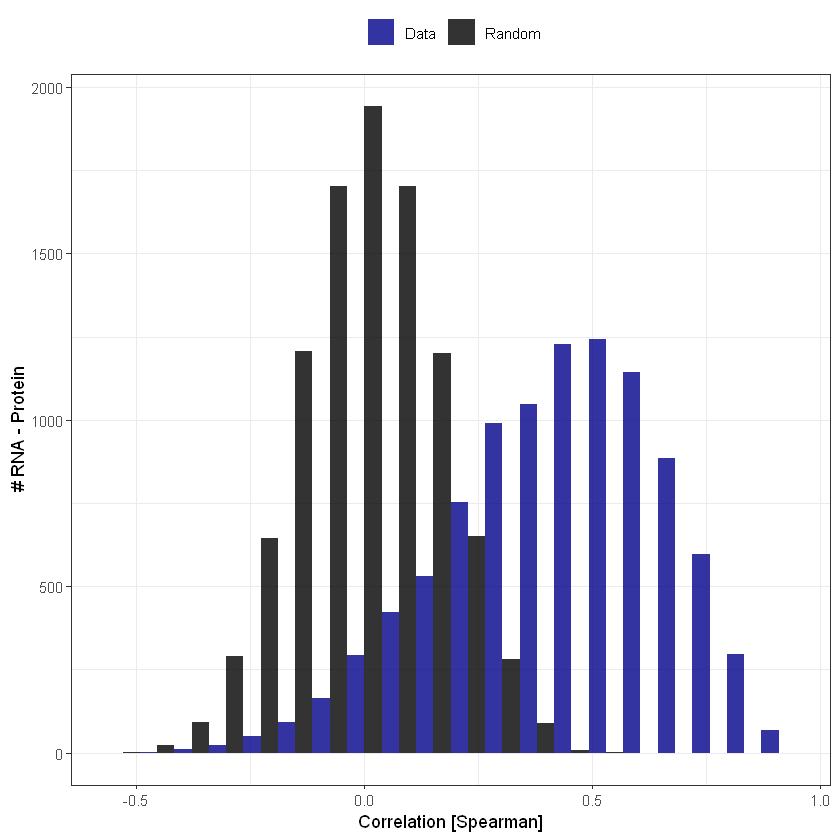

In [10]:
rnaProteinCorDF <- read.table(
    file = "resources/data/rna-protein.gz",
    header = T,
    sep = "\t",
    comment.char = "",
    quote = "",
    stringsAsFactors = F
) %>%
    filter(
        !is.na(mRNA_protein_correlation)
    )


# Generate random correlations

rnaProteinCorDF$random_correlation <- NA

for (i in 1:nrow(rnaProteinCorDF)) {
    
    x <- rnorm(45)
    y <- rnorm(45)
    
    rnaProteinCorDF$random_correlation[i] <- cor(
        x = x,
        y = y,
        method = "spearman"
    )
    
}

# Normalize the protein abundance, set missing values to the median

trainingDF <- rnaProteinCorDF %>%
    filter(
        !is.na(protein_copy_number)
    )

trainingDF$x <- 0

model <- gamlss(
    formula = as.formula("protein_copy_number ~ x"),
    family = LOGNO,
    data = trainingDF,
    
)

trainingDF$z_protein_copy_number <- centiles.pred(
    obj = model, 
    xname = "x", 
    xvalues = trainingDF$x, 
    yval = trainingDF$protein_copy_number, 
    type = "z-scores"
)

rnaProteinCorDF <- trainingDF %>%
    select(
        gene, z_protein_copy_number
    ) %>%
    right_join(
        rnaProteinCorDF,
        by = "gene"
    ) %>%
    mutate(
        z_protein_copy_number = ifelse(is.na(z_protein_copy_number), 0, z_protein_copy_number)
    )


# Transform the data frame from wide to long format

rnaProteinCorLongDF <- rnaProteinCorDF %>%
    gather(
        mRNA_protein_correlation, random_correlation,
        key = "data",
        value = "correlation"
    ) %>%
    mutate(
        data = ifelse(data == "mRNA_protein_correlation", "Data", "Random")
    ) %>%
    arrange(
        desc(data)
    )


# Build plot

ggplot(
    data = rnaProteinCorLongDF
) +
    geom_histogram(
        mapping = aes(
            x = correlation,
            fill = data
        ),
        alpha = 0.8,
        bins = 20,
        position = "dodge"
    ) +
    scale_x_continuous(
        name = "Correlation [Spearman]"
    ) +
    scale_y_continuous(
        name = "# RNA - Protein"
    ) +
    scale_fill_manual(
        values = c("darkblue", "black")
    ) +
    theme(
        legend.position = "top",
        legend.title = element_blank()
    )


##### [❔](https://github.com/GTPB/IBIP19/blob/master/pages/proteogenomics/answers.md#what-are-the-advantages-and-shortcomings-of-using-transcript-sequences-instead-of-or-in-addition-to-genomic-data) _How does the correlation evolve relatively to the abundance of the protein? Should it be used as covariate? What other protein characteristics could influence the correlation?_

##### 👨‍💻 Compute Z-scores of the correlation, plot scaled correlation against correlation.

GAMLSS-RS iteration 1: Global Deviance = -602.3349 
GAMLSS-RS iteration 2: Global Deviance = -602.3349 
GAMLSS-RS iteration 1: Global Deviance = -9390.38 
GAMLSS-RS iteration 2: Global Deviance = -9390.38 


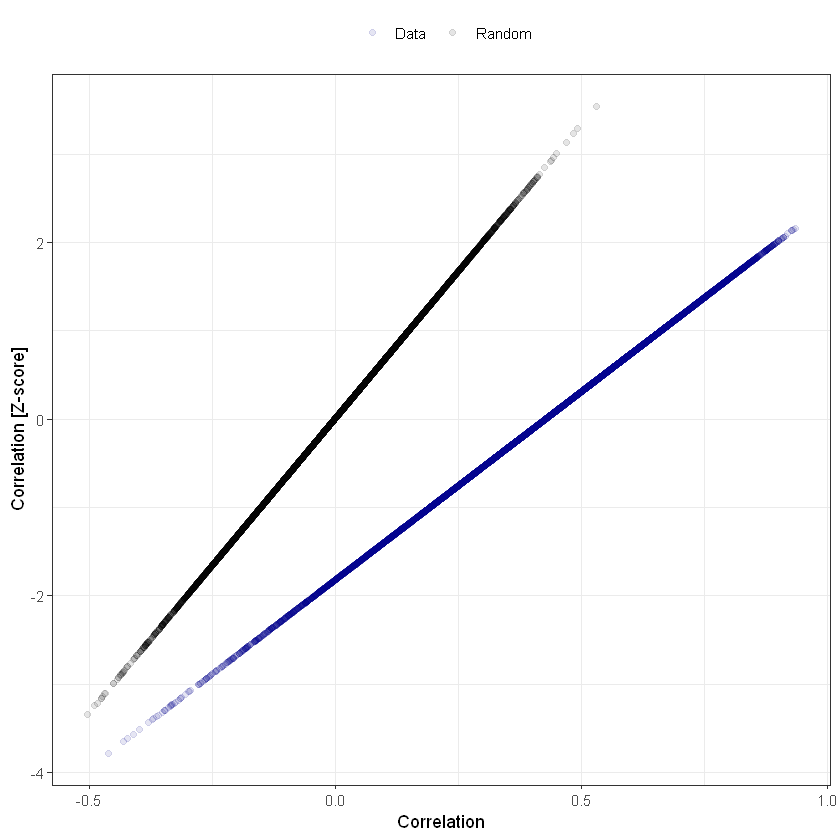

In [11]:

# Normalize the correlation

rnaProteinCorDF$x <- 0

model <- gamlss(
    formula = as.formula("mRNA_protein_correlation ~ x"),
    family = NO,
    data = rnaProteinCorDF[, c("mRNA_protein_correlation", "x")]
)

rnaProteinCorDF$z_mRNA_protein_correlation <- centiles.pred(
    obj = model, 
    xname = "x", 
    xvalues = rnaProteinCorDF$x, 
    yval = rnaProteinCorDF$mRNA_protein_correlation, 
    type = "z-scores"
)

model <- gamlss(
    formula = as.formula("random_correlation ~ x"),
    family = NO,
    data = rnaProteinCorDF[, c("random_correlation", "x")]
)

rnaProteinCorDF$z_random_correlation <- centiles.pred(
    obj = model, 
    xname = "x", 
    xvalues = rnaProteinCorDF$x, 
    yval = rnaProteinCorDF$random_correlation, 
    type = "z-scores"
)


# Transform the data frame from wide to long format

z_rnaProteinCorLongDF <- rnaProteinCorDF %>%
    select(
        gene, z_mRNA_protein_correlation, z_random_correlation
    ) %>%
    gather(
        z_mRNA_protein_correlation, z_random_correlation,
        key = "data",
        value = "z_correlation"
    ) %>%
    mutate(
        data = ifelse(data == "z_mRNA_protein_correlation", "Data", "Random")
    ) %>%
    arrange(
        desc(data)
    )

rnaProteinCorLongDF <- rnaProteinCorLongDF %>%
    left_join(
        z_rnaProteinCorLongDF,
        by = c("gene", "data")
    )


# Build plot

ggplot(
    data = rnaProteinCorLongDF
) +
    geom_point(
        mapping = aes(
            x = correlation,
            y = z_correlation,
            col = data
        ),
        alpha = 0.1
    ) +
    scale_x_continuous(
        name = "Correlation"
    ) +
    scale_y_continuous(
        name = "Correlation [Z-score]"
    ) +
    scale_color_manual(
        values = c("darkblue", "black")
    ) +
    theme(
        legend.position = "top",
        legend.title = element_blank()
    )


## Reduced correlation through participation in complexes and biochemical reactions

Johansson _et al._ [(2)](https://gtpb.github.io/IBIP19/pages/proteogenomics/references) show that the correlation between transcript and protein abundances is influenced by the involvement of proteins in complexes and protein-protein interactions (PPIs). Like in the [_CNA-protein_](CNA-Protein.ipynb) chapter, we are now going to investigate the relationship between RNA-protein correlation and protein participation in complexes, biochemical reactions, and PPIs.

##### 👨‍💻 Load the identifiers mapping as done in the [_CNA-protein_](CNA-Protein.ipynb) chapter.

In [12]:

# Uniprot accession mapping

accessionsMapping <- read.table(
    file = "resources/data/HUMAN_9606_idmapping.dat.gz", 
    header = F, 
    sep = "\t", 
    quote = "", 
    comment.char = "", 
    stringsAsFactors = F
)
names(accessionsMapping) <- c("accession", "source", "gene")
accessionsMapping <- accessionsMapping %>%
    filter(
        source == "Gene_Name"
    ) %>%
    select (
        gene, accession
    ) %>%
    filter(
        gene %in% rnaProteinCorDF$gene
    ) %>%
    distinct()

# Exclude gene mapping with more than 10 proteins per gene

geneOccurenceDF <- as.data.frame(
    x = table(accessionsMapping$gene), 
    stringsAsFactors = F
)
names(geneOccurenceDF) <- c("gene", "nProteins")

excludedGenes <- geneOccurenceDF$gene[geneOccurenceDF$nProteins >= 100]

##### 👨‍💻 Load complex data, plot the RNA-protein correlation against the number of complexes a protein is involved in.

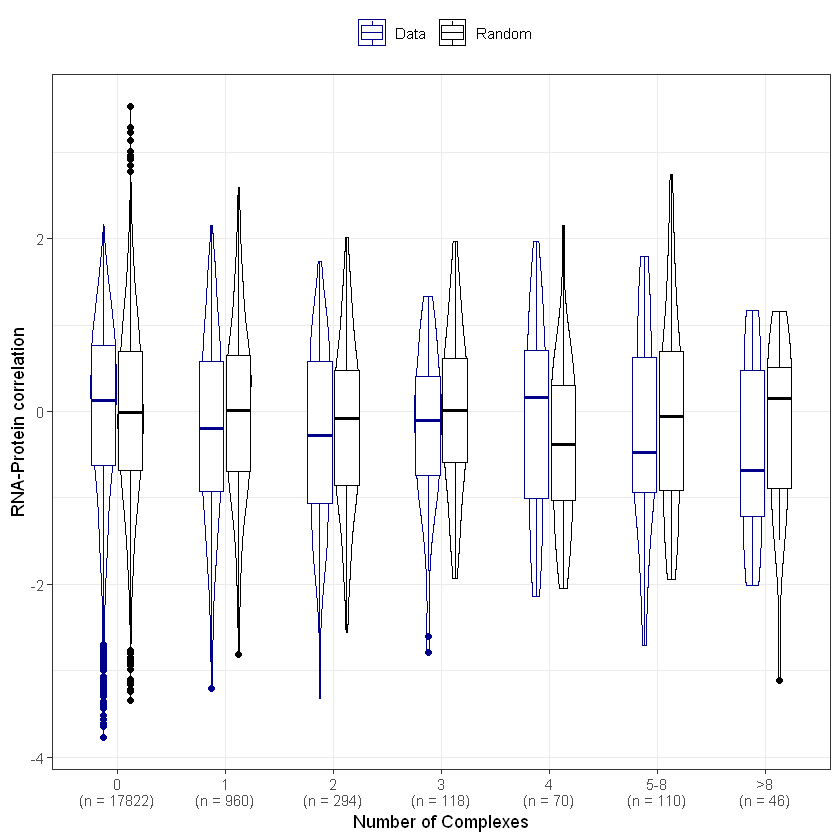

In [13]:
# Complexes

complexesDF <- read.table(
    file = "resources/data/complexes.03.11.19.tsv.gz", 
    header = T, 
    sep = "\t", 
    stringsAsFactors = F, 
    quote = "", 
    comment.char = ""
)


# Extract the protein to complex link, extract protein pairs involved in the same complex

complexesParticipantsList <- list()
complexesEdgesList <- list()

for (i in 1:nrow(complexesDF)) {
    
    complex <- complexesDF$complex_accession[i]
    participants <- complexesDF$participants_stoichiometry[i]
    
    proteinsSplit <- strsplit(
        x = participants,
        split = "\\|"
    )[[1]]
    participantsList <- strsplit(
        x = proteinsSplit,
        split = "[\\(\\)]"
    )
    
    participantsDF <- as.data.frame(
        t(
            unname(
                as.data.frame(
                    participantsList,
                    stringsAsFactors = F
                )
            )
        ),
        stringsAsFactors = F
    )
    names(participantsDF) <- c("protein", "stoichiometry")
    participantsDF$complex = complex
    
    complexesParticipantsList[[i]] <- participantsDF
    
    edgesDF <- data.frame(
        from = rep(participantsDF$protein, times = nrow(participantsDF)),
        to = rep(participantsDF$protein, each = nrow(participantsDF)),
        stringsAsFactors = F
    ) %>%
        filter(
            from != to
        ) %>%
        mutate(
            complex = complex
        )
    
    complexesEdgesList[[i]] <- edgesDF
    
}

complexesParticipantsDF <- do.call("rbind", complexesParticipantsList)
edgesComplexes <- do.call("rbind", complexesEdgesList)


# Get the number of complexes per gene

nComplexesPerProteinDF <- complexesParticipantsDF %>%
    group_by(
        protein
    ) %>%
    summarise(
        n = n()
    ) %>%
    rename(
        accession = protein
    )

rnaComplexesDF <- accessionsMapping %>%
    filter(
        !gene %in% excludedGenes
    ) %>% 
    left_join(
        nComplexesPerProteinDF,
        by = "accession"
    ) %>%
    mutate(
        n = ifelse(is.na(n), 0, n)
    ) %>%
    select(
        -accession
    ) %>%
    distinct() %>%
    group_by(
        gene
    ) %>%
    summarise(
        n = sum(n)
    ) %>% 
    ungroup() %>%
    inner_join(
        rnaProteinCorLongDF,
        by = "gene"
    ) 


# Build plot

rnaComplexesDF$nFactor <- factor(
    x = ifelse(rnaComplexesDF$n > 8, ">8", 
               ifelse(rnaComplexesDF$n > 4, "5-8", as.character(rnaComplexesDF$n))),
    levels = as.character(c(0:9, "5-8", ">8"))
)

levels <- levels(rnaComplexesDF$nFactor)

for (i in 1:length(levels)) {
    
    level <- levels[i]
    
    n <- sum(rnaComplexesDF$nFactor == level)
    
    level <- paste0(level, "\n(n = ", n, ")")
    
    levels[i] <- level
    
}

levels(rnaComplexesDF$nFactor) <- levels

ggplot(
    data = rnaComplexesDF
) +
    geom_violin(
        mapping = aes(
            x = nFactor,
            y = z_correlation,
            col = data
        ), 
        alpha = 0.1,
        width = 0.5
    ) +
    geom_boxplot(
        mapping = aes(
            x = nFactor,
            y = z_correlation,
            col = data
        ),
        width = 0.5
    ) +
    scale_x_discrete(
        name = "Number of Complexes"
    ) +
    scale_y_continuous(
        name = "RNA-Protein correlation"
    ) +
    scale_color_manual(
        values = c("darkblue", "black")
    ) +
    theme(
        legend.position = "top",
        legend.title = element_blank()
    )


##### 💬 According to this analysis, does the participation in complexes seem to be associated with CNA attenuation? How does this compare to CNA attenuation?

##### 👨‍💻 Load pathway data, plot the RNA-protein correlation against on the number of reactions a protein is involved in.

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 7608 rows containing non-finite values (stat_smooth)."


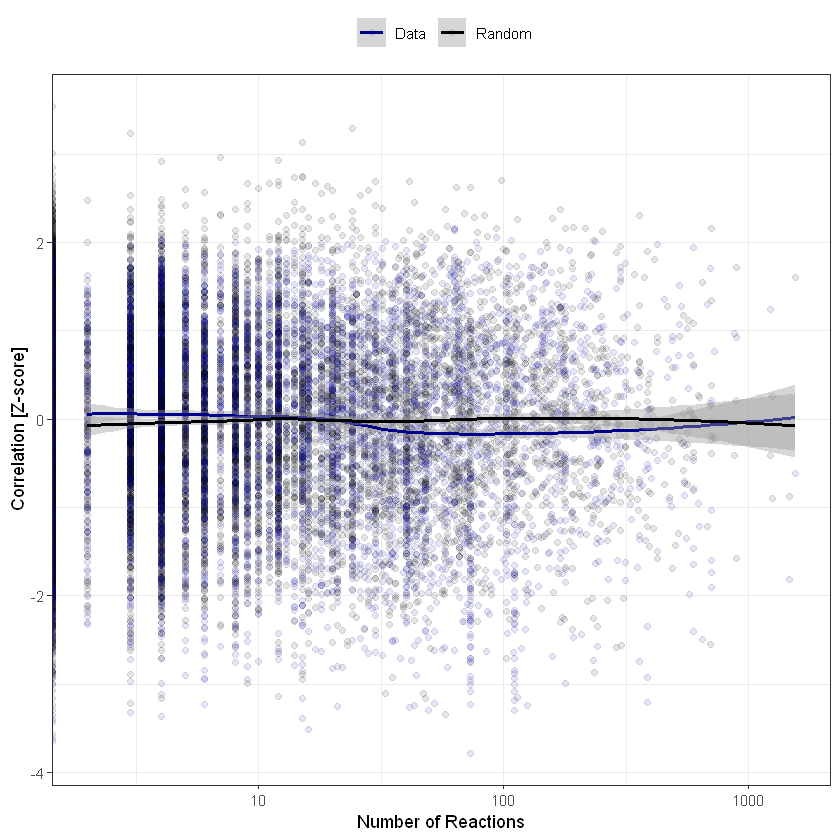

In [14]:

# Protein reactions from Reactome

reactomeSearchDF <- read.table(
    file = "resources/data/search.tsv.gz", 
    header = T, 
    sep = "\t", 
    stringsAsFactors = F, 
    quote = "", 
    comment.char = ""
)


# Get the number of reactions per gene

nReactionsPerProteinDF <- reactomeSearchDF %>%
    select(
        UNIPROT, REACTION_STID
    ) %>%
    rename(
        protein = UNIPROT,
        reaction = REACTION_STID
    ) %>%
    group_by(
        protein
    ) %>%
    summarise(
        n = n()
    ) %>%
    rename(
        accession = protein
    )

rnaReactionsDF <- accessionsMapping %>%
    filter(
        !gene %in% excludedGenes
    ) %>% 
    left_join(
        nReactionsPerProteinDF,
        by = "accession"
    ) %>%
    mutate(
        n = ifelse(is.na(n), 0, n)
    ) %>%
    select(
        -accession
    ) %>%
    distinct() %>%
    group_by(
        gene
    ) %>%
    summarise(
        n = sum(n)
    ) %>% 
    ungroup() %>%
    inner_join(
        rnaProteinCorLongDF,
        by = "gene"
    )


# Build plot

ggplot(
    data = rnaReactionsDF
) +
    geom_point(
        mapping = aes(
            x = n,
            y = z_correlation,
            col = data
        ), 
        alpha = 0.1
    ) +
    geom_smooth(
        mapping = aes(
            x = n,
            y = z_correlation,
            col = data
        ),
        method = "loess"
    ) +
    scale_x_log10(
        name = "Number of Reactions"
    ) +
    scale_y_continuous(
        name = "Correlation [Z-score]"
    ) +
    scale_color_manual(
        values = c("darkblue", "black")
    ) +
    theme(
        legend.position = "top",
        legend.title = element_blank()
    )


##### 💬 According to this analysis, does the participation in biochemical reactions seem to be associated with RNA correlation? How does this compare to CNA attenuation?

##### 👨‍💻 Load PPI data, plot the RNA-protein correlation against on the number of interactors a protein has.

Warning message:
"Removed 3190 rows containing non-finite values (stat_smooth)."


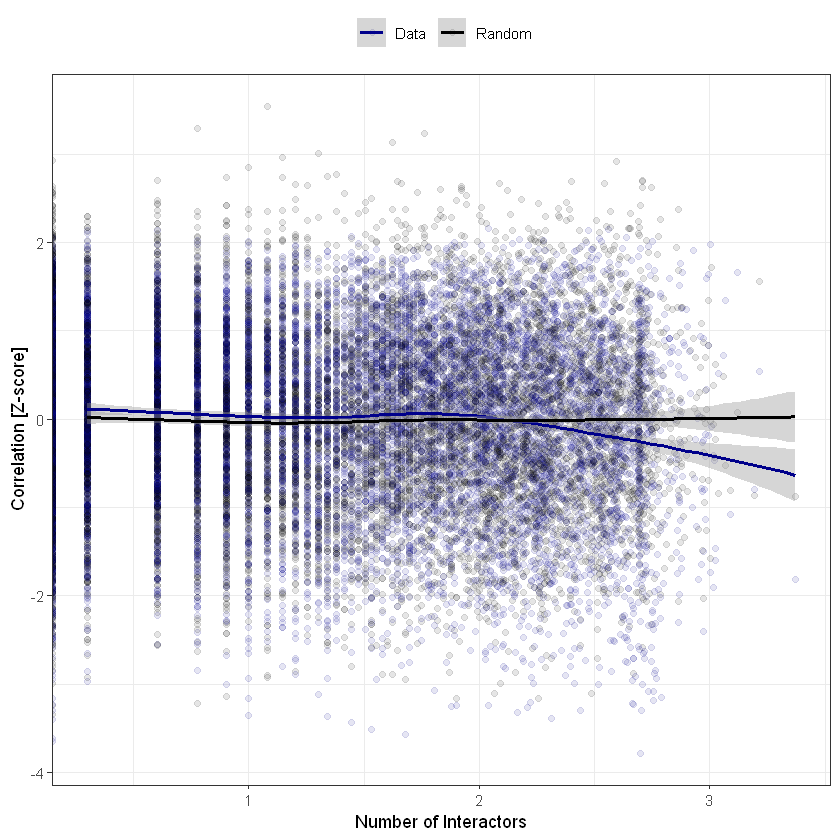

In [15]:
# Protein interactions from String

edgesString <- read.table(
    file = "resources/data/string_v10.5_high_edges.gz", 
    header = T, 
    sep = " ", 
    stringsAsFactors = F, 
    quote = "", 
    comment.char = ""
)


# Build and clean graph

graphString <- graph_from_data_frame(edgesString)
graphString <- simplify(graphString, remove.multiple = T, remove.loops = T, edge.attr.comb = "first")


# Build degree data frame

degreeDF <- data.frame(
    accession = V(graphString)$name,
    degree = degree(graphString),
    stringsAsFactors = F
)


# Get the number of interactors per gene

rnaDegreeDF <- accessionsMapping %>%
    filter(
        !gene %in% excludedGenes
    ) %>% 
    left_join(
        degreeDF,
        by = "accession"
    ) %>%
    mutate(
        degree = ifelse(is.na(degree), 0, degree)
    ) %>%
    select(
        -accession
    ) %>%
    distinct() %>%
    group_by(
        gene
    ) %>%
    summarise(
        degree = sum(degree)
    ) %>% 
    ungroup() %>%
    inner_join(
        rnaProteinCorLongDF,
        by = "gene"
    )


# Build plot

ggplot(
    data = rnaDegreeDF
) +
    geom_point(
        mapping = aes(
            x = log10(degree),
            y = z_correlation,
            col = data
        ), 
        alpha = 0.1
    ) +
    geom_smooth(
        mapping = aes(
            x = log10(degree),
            y = z_correlation,
            col = data
        ),
        method = "loess"
    ) +
    scale_x_continuous(
        name = "Number of Interactors"
    ) +
    scale_y_continuous(
        name = "Correlation [Z-score]"
    ) +
    scale_color_manual(
        values = c("darkblue", "black")
    ) +
    theme(
        legend.position = "top",
        legend.title = element_blank()
    )

##### 💬 According to this analysis, does the number of interactors seem to be associated with RNA correlation? How does this compare to reactions? To CNA attenuation?

In the following, we investigate whether the proteins participating in specific pathways have increased or decreased significance level.

##### 👨‍💻 Gather the mean correlation for each pathway, investigate the significance of the difference between the data and random correlation.

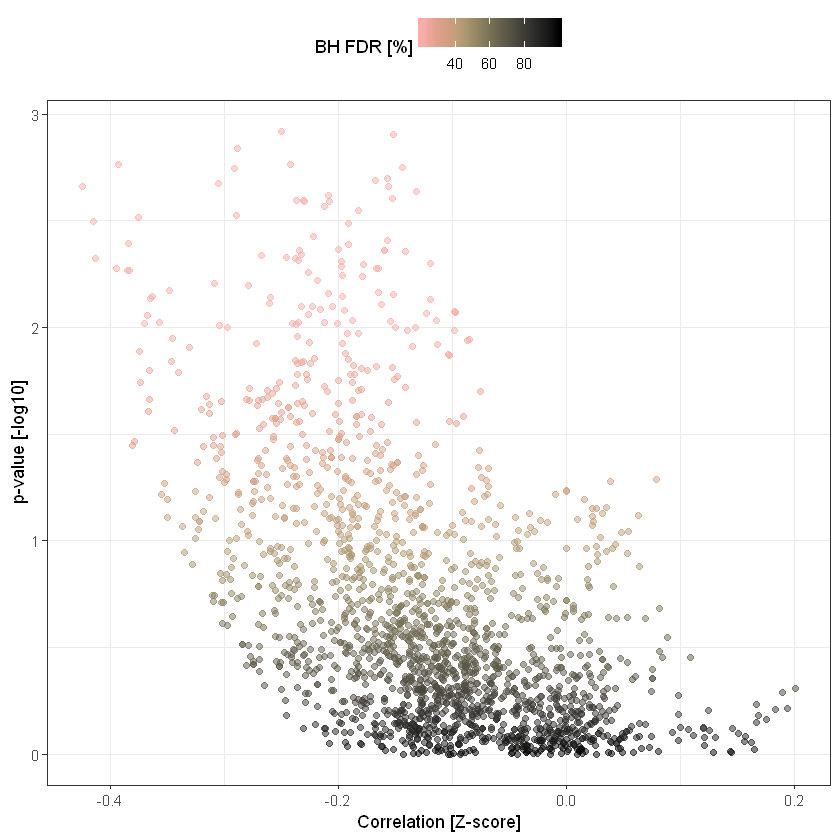

In [19]:
# Gather the correlation per pathway

pathwaysDF <- reactomeSearchDF %>%
    select(
        PATHWAY_STID, PATHWAY_DISPLAY_NAME
    ) %>%
    distinct() %>%
    mutate(
        z_mRNA_protein_correlation = NA,
        z_random_correlation = NA,
        p = NA
    )

for (i in 1:nrow(pathwaysDF)) {
    
    pathwayId <- pathwaysDF$PATHWAY_STID[i]
    proteins <- reactomeSearchDF$UNIPROT[pathwaysDF$PATHWAY_STID == pathwayId]
    genes <- accessionsMapping$gene[accessionsMapping$accession %in% proteins]
    
    z_mRNA_protein_correlation <- rnaProteinCorDF$z_mRNA_protein_correlation[rnaProteinCorDF$gene %in% genes]
    z_random_correlation <- rnaProteinCorDF$z_random_correlation[rnaProteinCorDF$gene %in% genes]
    
    tTest <- t.test(
        x = z_random_correlation,
        y = z_mRNA_protein_correlation,
        alternative = "two.sided"
    )
    
    p <- tTest$p.value
    
    pathwaysDF$z_mRNA_protein_correlation[i] <- mean(z_mRNA_protein_correlation)
    pathwaysDF$z_random_correlation[i] <- mean(z_random_correlation)
    pathwaysDF$p[i] <- p
    
}

# Correct for multiple hypothesis testing

pathwaysDF <- pathwaysDF %>%
    arrange(
        desc(p)
    ) %>%
    mutate(
        bhFDR = 100 * p.adjust(p, method = "BH")
    )

# Make a Volcano plot

ggplot(
    data = pathwaysDF
) + 
    geom_point(
        mapping = aes(
            x = z_mRNA_protein_correlation,
            y = -log10(p),
            col = bhFDR
        ),
        alpha = 0.5
    ) +
    scale_x_continuous(
        name = "Correlation [Z-score]"
    ) +
    scale_y_continuous(
        name = "p-value [-log10]"
    ) + 
    scale_color_scico(
        name = "BH FDR [%]",
        palette = "turku",
        direction = -1,
        end = 0.8
    ) +
    theme(
        legend.position = "top"
    )



##### 💬 What do you think of the significance levels?

##### 👨‍💻 Build a Q-Q plot based on these p-values.

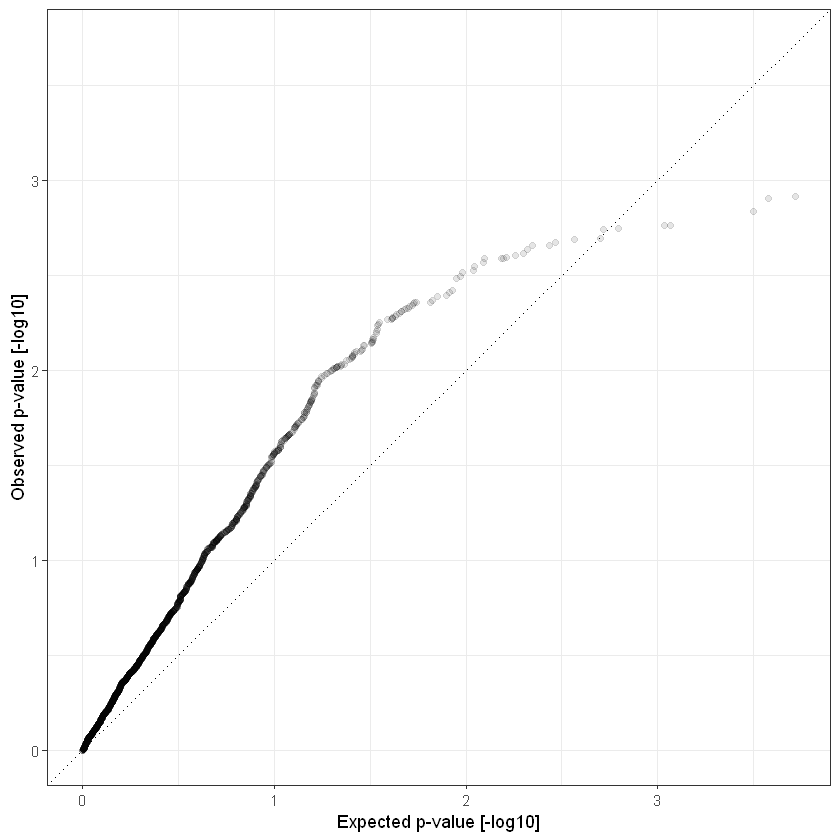

In [20]:
expectedPvalues <- -log10(
    sort(
        runif(
            n = nrow(pathwaysDF)
        )
    )
)
observedPvalues <- -log10(
    sort(
        pathwaysDF$p
    )
)

maxP <- max(c(expectedPvalues, observedPvalues))

ggplot() +
    geom_abline(
        slope = 1,
        intercept = 0,
        linetype = "dotted"
    ) +
    geom_point(
        mapping = aes(
            x = expectedPvalues,
            y = observedPvalues
        ),
        alpha = 0.1
    ) +
    scale_x_continuous(
        name = "Expected p-value [-log10]",
        limits = c(0, maxP)
    ) +
    scale_y_continuous(
        name = "Observed p-value [-log10]",
        limits = c(0, maxP)
    )

##### [❔](https://github.com/GTPB/IBIP19/blob/master/pages/proteogenomics/answers.md#what-are-the-advantages-and-shortcomings-of-using-transcript-sequences-instead-of-or-in-addition-to-genomic-data) What can influence the distribution of p-values

##### 👨‍💻 Extract the pathways most associated with correlation.

##### 💬 How can we use this information for biological or clinical interpretation?

In [25]:
head(pathwaysDF %>% arrange(p), n = 20)

PATHWAY_STID,PATHWAY_DISPLAY_NAME,z_mRNA_protein_correlation,z_random_correlation,p,bhFDR
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
R-HSA-388844,Receptor-type tyrosine-protein phosphatases,-0.2501121,0.15902928,0.001206253,20.67506
R-HSA-450282,MAPK targets/ Nuclear events mediated by MAP kinases,-0.1516243,0.25880265,0.001240823,20.67506
R-HSA-74713,IRS activation,-0.2887619,0.11753415,0.001454270,20.67506
R-HSA-110331,Cleavage of the damaged purine,-0.2418464,0.15972250,0.001718867,20.67506
R-HSA-211736,Stimulation of the cell death response by PAK-2p34,-0.3927891,0.02441929,0.001728199,20.67506
R-HSA-202670,ERKs are inactivated,-0.1435027,0.25239817,0.001778163,20.67506
R-HSA-982772,Growth hormone receptor signaling,-0.2909319,0.10973770,0.001800192,20.67506
R-HSA-110056,MAPK3 (ERK1) activation,-0.1565051,0.23865081,0.002010471,20.67506
R-HSA-74751,Insulin receptor signalling cascade,-0.1671471,0.22611957,0.002037867,20.67506
